In [1]:


import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import KBinsDiscretizer , StandardScaler
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.pipeline import make_pipeline , Pipeline
from sklearn.svm import SVR
from sklearn.metrics import r2_score , explained_variance_score
from scipy import stats
from scipy.special import boxcox, inv_boxcox

%matplotlib inline

In [2]:
def load_data ():
    '''
    load data
    IMPUT:
    OUTPUT: type_1 , type_2 , type_3 , type_4 (dataFrame) processed data from 02_data pre-processing
    '''  
    # read in the csv files
    type_1 = pd.read_csv('data/amount_type_1.csv').drop(columns = 'user id')
    type_2 = pd.read_csv('data/amount_type_2.csv').drop(columns = 'user id')
    type_3 = pd.read_csv('data/amount_type_3.csv').drop(columns = 'user id')
    type_4 = pd.read_csv('data/amount_type_4.csv').drop(columns = 'user id')

    return type_1 , type_2 , type_3 , type_4

# clear outliers

In [3]:
def clear_outliers (df , col , max_offer):
    '''
    drop outsiders
    IMPUT:
        df (dataFrame) - data to be modify
        col (str) - name of the column that has NaN values to clear
        max_offer (int) -   maximum value spected in a transaction influenced by an offer 
                            (e.g. someone that spend more than 1000$ it's unlikely that was influenced by an offer)
    OUTPUT:
        df (dataFrame) without outsiders
    '''  
    #remove values > max_offer 
    df = df.drop(df[df[col] > max_offer ].index)
    
    #round values
    df[col] = (df[col] * 10).round(0)
    df = df.astype(int)
    
    #removing value 0
    df = df.drop(df[df[col] == 0 ].index)
    
    return df

# Bucketize

In [4]:
def bucketizer(df , col, bins=10):
    '''
    Create buckets for a given column
    IMPUT:
        df (dataFrame) - data to be modify
        col (str) - name of the column to be bucketize
        bins (int) - number of bins to be created
    OUTPUT:
        values_pp (Series) Serie of the bucketize column
    '''
    values_np = df[col].values.reshape(-1,1)
    bucketizer = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform').fit(values_np)
    values_pp = bucketizer.transform(values_np)
    
    return values_pp    

In [5]:
def split_data(df , label):
    '''
    split data set into Train and Test
    IMPUT:
        df (dataFrame)
        label (str) - name of the label to be predicted
    OUTPUT:
        X_train, X_test  (dataFrame) split data Train - Test
        y_train_box, y_test (Series) split data Train - Test
    '''
    
    X = df.drop(columns = [label])
    y = df[label]

    X_train, X_test, y_train, y_test = train_test_split(X, y , random_state=42)
         
    return X_train, X_test, y_train, y_test


def log_box_cox (y_train):
    '''
    Apply log (box-cox) to the y_Train to have a normal distribution of the data
    IMPUT: y_train (Series)
    OUTPUT:
        y_train_box (Series) data after log
        maxlog - (int) value of the lmbda parameter to reverse the applied log
    '''
    box_train , maxlog = stats.boxcox(y_train)
    y_train_box = pd.Series(box_train)

    return y_train_box , maxlog


def train_model (X_train , y_train):
    '''
    train model
    IMPUT:
        X_train (dataFrame)
        y_train (series)
    OUTPUT:
        clf (Pipeline) fit model pipeline
    '''       
    clf = make_pipeline(StandardScaler() , SVR())
    clf.fit(X_train, y_train)
    
    return clf

def grid (clf , X_train , y_train):
    '''
    apply GridSearchCV to the pipeline to get best parameters
    IMPUT:
        clf (Pipeline) fit model pipeline
        X_train (dataFrame)
        y_train (series)
    OUTPUT:
        grid (Pipeline) fit model pipeline with best parameters
    ''' 
    
    parameters = {
        'svr__kernel': ('linear', 'poly' , 'rbf'),
        'svr__C' : (0.5 , 0.75 , 1.0),
        'svr__shrinking' : (True , False),
        'svr__gamma': ('scale','auto')
    }
    
    grid = GridSearchCV(clf, param_grid=parameters)
    grid.fit(X_train,y_train)
    print("\nBest Parameters:", grid.best_params_)
    
    return grid

def predict (clf , X_test , maxlog , log=True):
    '''
    predict values
    IMPUT:
        clf (Pipeline)
        X_test (dataFrame)
        maxlog (int) - value of the lmbda parameter to reverse the applied log
        log - (boolean) if true apply log (box-cox)
        
    OUTPUT: 
        y_pred (array) test prediction 
    '''
    
    predictions = clf.predict(X_test)
    if log:
        y_pred = inv_boxcox(predictions, maxlog)
        y_pred = np.nan_to_num(y_pred)  # in some cases inv_boxcox can return a NaN (when is a complex number)
    else:
        y_pred = predictions
   
    return y_pred

def build_model (df , label , max_offer, log=True , bucket=True , outsiders=True):
    '''
    create and train the model
    IMPUT:
        df (dataFrame) data set of for a type of offer
        label (str) - name of the label to be predicted
        max_offer (int)
        *** the purpose of the following booleans is to create visual graph to represent the evolution of the model
        log - (boolean) if true apply log (box-cox) 
        bucket - (boolean) if true apply bucketizer
        outsiders - (boolean) if true apply clear_outliers
        
    OUTPUT:
        X_train, X_test  (dataFrame) 
        y_train , y_test (Series)
        y_pred (array) test prediction 
        label (str) - name of the label to be predicted
        max_offer (int)
        model (Pipelane) model with best parameters
        maxlog (int) - value of the lmbda parameter to reverse the applied log
    '''

    #clear outliers
    if outsiders:
        df = clear_outliers (df , label ,  max_offer)
    
    #bucketizer
    if bucket:
        df['age'] = bucketizer(df , 'age' , 8)
        df['income'] = bucketizer(df , 'income' , 9)
    
    #split into train and test
    X_train, X_test, y_train, y_test = split_data (df , label)

    if log:
        y_train , maxlog = log_box_cox (y_train)
    else:
        maxlog = 0

    clf = train_model (X_train , y_train)
    grid_pipeline = grid(clf, X_train , y_train)
    model = grid_pipeline.best_estimator_

    y_pred = predict (model , X_test , maxlog , log )
    
    return X_train , X_test , y_train , y_test , y_pred , label , max_offer , model , maxlog


def print_results(y_train , y_test , y_pred , label , max_offer):
    '''
    print results
    IMPUT:
        y_train , y_test (Series)
        y_pred (array) test prediction 
        label (str) - name of the label to be predicted
        max_offer (int)
        
    OUTPUT:  
    '''
    r2 = r2_score(y_test, y_pred)
    e_variance = explained_variance_score(y_test, y_pred)

    print ('r2 score =' , r2)
    print ('Adjusted R-Squared =' , e_variance)

    mu = y_train.mean()  # mean of distribution
    sigma = np.std(y_train)  # standard deviation of distribution
    
    num_bins = 100
    f1, ax1 = plt.subplots()

    n, bins, patches = ax1.hist(y_train, num_bins, density=1)

    # add a 'best fit' line

    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
         np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    ax1.plot(bins, y, '--')
    ax1.set_xlabel('amount transaction ($) - label data')
    ax1.set_ylabel('Number of users')
    ax1.set_title('data to be trained - checking if its a normal distribution')

    # Tweak spacing to prevent clipping of ylabel
    f1.tight_layout()
    plt.show();        
       
    f2, ax2 = plt.subplots()
    ax2.plot(range(max_offer * 10))
    f2.suptitle(label, fontsize=15)
    plt.xlabel('train values')
    plt.ylabel('prediction values')
    ax2.scatter(y_test.values , y_pred , s=10 , c='r')
    plt.show();


In [6]:
#load data
type_1 , type_2 , type_3 , type_4 = load_data ()

In [7]:
#rename columns to have same name for each data set
type_1.rename(columns={'offers type 1': 'offers', 'viewed type 1': 'viewed' , 'completed type 1' : 'completed'} , inplace=True)
type_2.rename(columns={'offers type 2': 'offers', 'viewed type 2': 'viewed' , 'completed type 2' : 'completed'} , inplace=True)
type_3.rename(columns={'offers type 3': 'offers', 'viewed type 3': 'viewed' , 'completed type 3' : 'completed'} , inplace=True)

In [8]:
# type 1 bogo
X_train_1 , X_test_1 , y_train_1 , y_test_1 , y_pred_1 , label_1 , max_offer_1 , bogo_model , bogo_maxlog = build_model(type_1 , 'type 1' , 40)


Best Parameters: {'svr__C': 1.0, 'svr__gamma': 'scale', 'svr__kernel': 'rbf', 'svr__shrinking': True}


In [9]:
# type 2 Informational
X_train_2 , X_test_2 , y_train_2 , y_test_2 , y_pred_2 , label_2 , max_offer_2 , info_model , info_maxlog = build_model(type_2 , 'type 2' , 40)


Best Parameters: {'svr__C': 0.75, 'svr__gamma': 'auto', 'svr__kernel': 'rbf', 'svr__shrinking': False}


In [10]:
# type 3 Discount
X_train_3 , X_test_3 , y_train_3 , y_test_3 , y_pred_3 , label_3 , max_offer_3 , disc_model , disc_maxlog = build_model(type_3 , 'type 3' , 40)


Best Parameters: {'svr__C': 1.0, 'svr__gamma': 'scale', 'svr__kernel': 'rbf', 'svr__shrinking': False}


In [11]:
# type 4 No offer
X_train_4 , X_test_4 , y_train_4 , y_test_4 , y_pred_4 , label_4 , max_offer_4 , no_offer_model , no_offer_maxlog = build_model(type_4 , 'type 4' , 40)


Best Parameters: {'svr__C': 1.0, 'svr__gamma': 'auto', 'svr__kernel': 'poly', 'svr__shrinking': False}


r2 score = 0.6421523786202816
Adjusted R-Squared = 0.6452834703269721


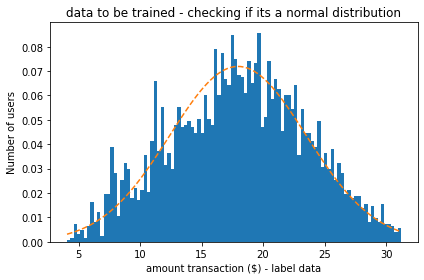

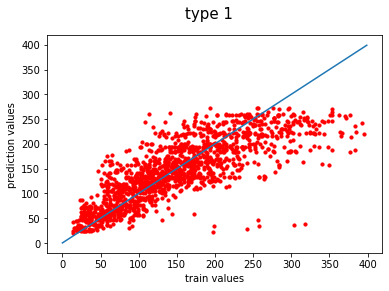

r2 score = 0.4295119296905079
Adjusted R-Squared = 0.44875786218626956


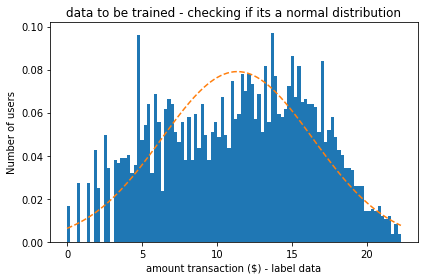

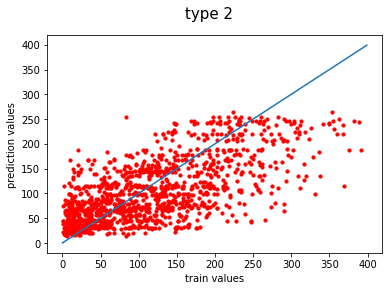

r2 score = 0.6540348652238173
Adjusted R-Squared = 0.6549696237194078


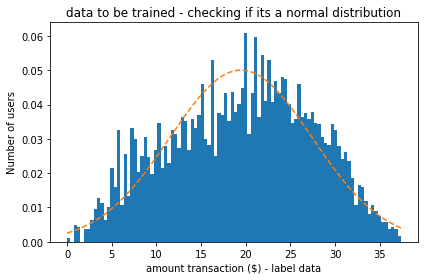

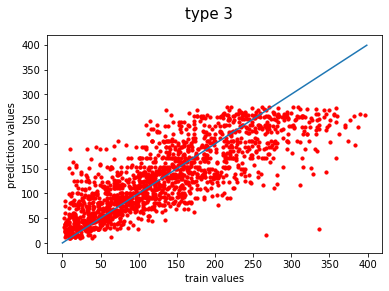

r2 score = 0.6246702925430527
Adjusted R-Squared = 0.6251411037648388


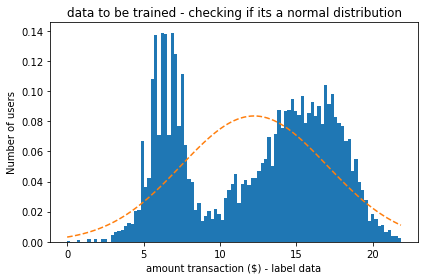

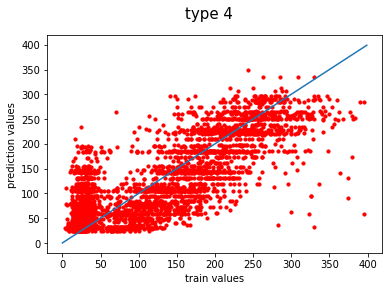

In [12]:
#print results
print_results (y_train_1 , y_test_1 , y_pred_1 , label_1 , max_offer_1)
print_results (y_train_2 , y_test_2 , y_pred_2 , label_2 , max_offer_2)
print_results (y_train_3 , y_test_3 , y_pred_3 , label_3 , max_offer_3)
print_results (y_train_4 , y_test_4 , y_pred_4 , label_4 , max_offer_4)

# Checking max offer value

In [13]:
def check_max_offer(df , label , range_test):

    r2_lst = []

    for max_offer in range_test:

        dfi = clear_outliers (df , label ,  max_offer)       
        dfi['age'] = bucketizer(dfi , 'age' , 8)
        dfi['income'] = bucketizer(dfi , 'income' , 9)

        X_train, X_test, y_train, y_test = split_data (dfi , label)
        box_train , maxlog = stats.boxcox(y_train)
        y_train = pd.Series(box_train)   

        clf = make_pipeline(StandardScaler() , SVR())
        clf.fit(X_train, y_train)

        predictions = clf.predict(X_test)

        y_pred = inv_boxcox(predictions, maxlog)
        y_pred = np.nan_to_num(y_pred)  # in some cases inv_boxcox can return a NaN (when is a complex number)

        r2 = r2_score(y_test, y_pred)
        r2_lst.append(r2)

    f3, ax3 = plt.subplots()
    ax3.plot(range_test, r2_lst)
    ax3.plot(np.linspace(40,40,5) , np.linspace(0,0.8,5))

    ax3.set(xlabel='max offer ($)', ylabel='r2 score',
        title='max offer for a better r2 model result')
    ax3.grid()    

    plt.show()

In [14]:
range_test = range(10 , 500 , 10)

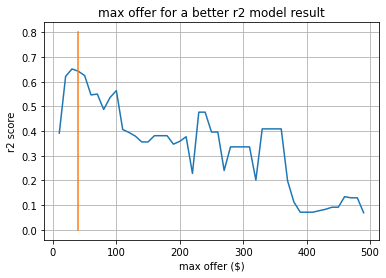

In [15]:
check_max_offer(type_1 , 'type 1' , range_test)

In [16]:
def check_epsilon(df , label , max_offer , range_epsilon_test):

    df = clear_outliers (df , label ,  max_offer)
    df['age'] = bucketizer(df , 'age' , 8)
    df['income'] = bucketizer(df , 'income' , 9)

    X_train, X_test, y_train, y_test = split_data (df , label)
    box_train , maxlog = stats.boxcox(y_train)
    y_train = pd.Series(box_train)

    r2_lst = []

    for e in range_epsilon_test:        

        clf = make_pipeline(StandardScaler() , SVR(epsilon=e))
        clf.fit(X_train, y_train)

        predictions = clf.predict(X_test)

        y_pred = inv_boxcox(predictions, maxlog)
        y_pred = np.nan_to_num(y_pred)  # in some cases inv_boxcox can return a NaN (when is a complex number)

        r2 = r2_score(y_test, y_pred)
        r2_lst.append(r2)

    f4, ax4 = plt.subplots()
    ax4.plot(range_epsilon_test, r2_lst)

    ax4.set(xlabel='epsilon', ylabel='r2 score',
        title='better epsilon value')
    ax4.grid()

    plt.show()

In [17]:
range_epsilon_test = np.linspace(0,1,11)

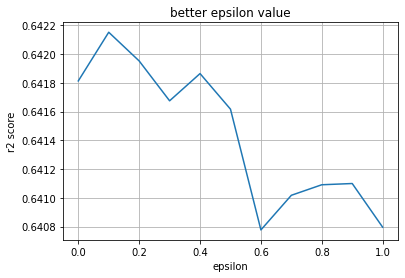

In [18]:
check_epsilon(type_1 , 'type 1' , 40 , range_epsilon_test)